**Постройте модель склонности клиента к покупке определённого товара при коммуникации**

# 0. Импорт библиотек

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, cross_val_score

# 1. Загрузка данных

In [2]:
# Загрузим данные
df_clean = pd.read_csv('data/df_clean.csv')
df_clean

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,personal_coef,marketing_one,no_discount,marketing_two,product_group,has_anomaly
0,0,3378,9,13599,0,1,7,0,36,1,1201,0.5072,0,0,0,881,1
1,0,18351,11,1499,3,0,37,0,36,1,1201,0.5072,0,0,0,5411,0
2,0,12608,0,4799,3,0,37,0,36,1,1201,0.5072,0,0,0,3196,0
3,3,2870,1,1599,1,0,13,1,31,1,1134,0.4304,0,0,0,803,0
4,3,12549,19,7199,3,0,27,1,31,1,1134,0.4304,0,0,0,3181,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780108,178004,13747,12,12,3,0,20,1,52,0,1188,0.4688,0,0,0,3735,0
780109,178004,9151,9,5999,1,0,9,1,52,0,1188,0.4688,0,0,0,2411,0
780110,178004,9367,9,13999,1,0,6,1,52,0,1188,0.4688,0,0,0,2422,1
780111,178004,5556,9,8699,1,0,9,1,52,0,1188,0.4688,0,0,0,1683,0


### Загрузка соответствий категориальных переменных

In [3]:
# считаем данные pickle-формате
with open('data/mappings.pickle', 'rb') as f:
    mappings = pickle.load(f)

# 2. Обработка данных

In [5]:
df_model = df_clean.copy()

**Преобразуем education с помощью OneHotEncoder, и поменяем названия столбцов.**

**Таргет выбирать буду таким образом, если товар покупался больше медианного значения то таргет будет 1, в противном случае 0.**

In [6]:
target = df_model.groupby(['product_group'], as_index=False)[['id']].count().rename(columns={'id': 'count'})
num_median = target['count'].median()
num_median

14.0

In [7]:
target[target['count']<=14].shape

(3551, 2)

In [8]:
target[target['count']>14].shape

(3475, 2)

In [9]:
# Создаем словарь, где ключи - товары, значения - частота встречаемости
# to_dict() преобразует Series в словарь
product_counts = df_model['product_group'].value_counts().to_dict()

# Создаем целевой столбец с помощью map()
# map() заменяет каждое значение в Series на соответствующее значение из словаря или функции
# lambda x - это анонимная функция, которая принимает один аргумент x (товар)
df_model['target'] = df_model['product_group'].map(lambda x: 1 if product_counts[x] > num_median else 0)

In [10]:
# Из данных убираем все строки с городом 1188
df_no1188 = df_model[df_model['city']!=1188]
df_no1188.shape

(691225, 18)

In [11]:
balance_target = df_no1188['target'].value_counts()
balance_target

target
1    676049
0     15176
Name: count, dtype: int64

**При определении таргета, получилось что таргет не сбалансирован. Поэтому таргет 1 убавим до до количества таргета 0.**

In [12]:
# Разделяем данные по классам
target1 = df_no1188[df_no1188['target'] == 1]  # Класс 1 (676049 строк)
target2 = df_no1188[df_no1188['target'] == 0]  # Класс 0 (15176 строк)

# Уменьшаем target1 до размера target2
target1_cropped = target1.sample(n=len(target2), random_state=42)

# Объединяем сбалансированные данные
df_balanced = pd.concat([target1_cropped, target2])

# Перемешиваем данные
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Проверим новый баланс классов
print("\nНовое распределение классов после балансировки:")
print(df_balanced['target'].value_counts())


Новое распределение классов после балансировки:
target
1    15176
0    15176
Name: count, dtype: int64


**Если товар покупался больше 14 раз(медиана), это будет означать что вероятнее всего товар купят.**

In [13]:
# удаление ненужных колонок
df_balanced = df_balanced.drop(['id', 'city', 'no_discount'], axis=1)

# удаляем:
# id - неиформативная фича
# city - потому что модель строим для одного города
# no_discount - это отмечалась контрольная группа в АБ тестировании

In [14]:
df_balanced.head()

,product,colour,cost,product_sex,base_sale,dt,gender,age,education,personal_coef,marketing_one,marketing_two,product_group,has_anomaly,target
0,14012,43,2699,3,0,40,1,26,0,0.4688,0,0,3819,0,1
1,7640,9,17199,3,0,34,0,39,1,0.5072,0,0,2344,1,1
2,16698,43,4599,3,0,21,1,23,0,0.4688,0,0,4860,0,1
3,3997,46,7199,1,0,6,1,17,0,0.2672,1,0,1051,1,1
4,16624,13,2519,0,1,1,0,16,0,0.2896,0,0,4818,1,0


# 3. Модель

**Задача машинного обучения Классификация - бинарная.**

In [15]:
x = df_balanced.drop(['target'], axis=1) # в х поместить весь датасет кроме целевой переменной
y = df_balanced['target'] # в у поместить только целевую переменную

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# разделить выборки на тестовый и тренировочный, зададим процент тестовой выборке 30% "test_size=0.3", 
# random_state по умолчанию NaN, нужен для генератора случайных чисел, нужно указать какое то число.
# Изменение значения random_state приведет к изменению результата.
# В библиотеке Scikit-learn этот параметр управляет перетасовкой данных перед их разделением. 
# Мы используем его в функции train_test_split для разделения данных на обучающую и тестовую выборки.

In [14]:
x_train.shape, x_test.shape

((21246, 14), (9106, 14))

In [233]:
x_train.head()

,product,colour,cost,product_sex,base_sale,dt,gender,age,education,personal_coef,marketing_one,marketing_two,product_group,has_anomaly
10579,14996,0,3919,0,1,47,1,53,1,0.4304,1,0,4306,0
28096,11082,9,6999,3,0,0,0,29,1,0.5072,0,0,2605,0
3043,3090,41,1014,2,1,46,0,37,1,0.5072,0,0,835,0
25608,19140,30,999,3,0,24,1,32,1,0.4304,0,0,5740,0
12129,11990,34,12999,3,0,0,1,35,1,0.4304,1,0,2953,1


In [236]:
y_train

10579    1
28096    0
3043     0
25608    1
12129    0
        ..
29802    0
5390     1
860      0
15795    0
23654    1
Name: target, Length: 21246, dtype: int64

**Определим одну лучшую модель из двух.**

In [15]:
# Сравнение нескольких моделей
models = {
    'Дерево решений': DecisionTreeClassifier(),
    'Случайный лес': RandomForestClassifier(),
    'Логистическая регрессия': LogisticRegression(solver='liblinear', max_iter=1000),
    'Многослойный персептрон': MLPClassifier(max_iter=1000)
}

for name, model in models.items():
    model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    print(f"{name}: Train = {train_score:.3f}, Test = {test_score:.3f}")

Дерево решений: Train = 1.000, Test = 0.893
Случайный лес: Train = 1.000, Test = 0.869
Логистическая регрессия: Train = 0.753, Test = 0.749
Многослойный персептрон: Train = 0.563, Test = 0.566


In [16]:
clf = DecisionTreeClassifier() # Обучение модели на тренеровочной выборке

In [ ]:
clf.fit(x_train, y_train)

In [17]:
predicted_train = clf.predict(x_train)
predicted_test = clf.predict(x_test)
# сделать предикт на тестовых и тренировочных данных

In [18]:
predicted_train.shape

(21246,)

In [19]:
predicted_train

array([1, 0, 0, ..., 0, 0, 1])

In [20]:
predicted_test.shape

(9106,)

In [21]:
predicted_test

array([1, 1, 0, ..., 1, 1, 1])

In [22]:
print('Точность тренировочной выборки: ', accuracy_score(y_train, predicted_train)*100)
print('Точность тестовой выборки: ', accuracy_score(y_test, predicted_test)*100)

Точность тренировочной выборки:  100.0
Точность тестовой выборки:  89.00724796837251


In [18]:
cross_validate(clf, x, y, cv=5)

{'fit_time': array([0.30565143, 0.25435233, 0.22263169, 0.23895049, 0.23060393]),
 'score_time': array([0.00535226, 0.00460482, 0.00463057, 0.00487542, 0.00482059]),
 'test_score': array([0.9087465 , 0.90149893, 0.90032949, 0.90263591, 0.89802306])}

In [21]:
sc_score = cross_val_score(clf, x, y, cv=5)

In [23]:
print(f'Оценка модели Кросс-Валидация, среднее значение: {sc_score.mean()}, стандартное отклонение: {sc_score.std()}')

Оценка модели Кросс-Валидация, среднее значение: 0.90152204406017, стандартное отклонение: 0.002842036518163225


In [24]:
# Сравнение нескольких моделей с помощью кросс валидации
models = {
    'Дерево решений': DecisionTreeClassifier(),
    'Случайный лес': RandomForestClassifier(),
    'Логистическая регрессия': LogisticRegression(solver='liblinear', max_iter=1000),
    'Многослойный персептрон': MLPClassifier(max_iter=1000)
}

for name, model in models.items():
    sc_score = cross_val_score(model, x, y, cv=5)
    print(f"{name}: sc_score = {sc_score.mean():.3f}, std = {sc_score.std():.3f}")

Дерево решений: sc_score = 0.903, std = 0.001
Случайный лес: sc_score = 0.875, std = 0.004
Логистическая регрессия: sc_score = 0.751, std = 0.004
Многослойный персептрон: sc_score = 0.564, std = 0.033


In [23]:
f_imp_list = list(zip(x_train.columns, clf.feature_importances_))
# создадим list в соответствии с названием колонки и коэффициентом важности
f_imp_list.sort(key = lambda x: x[1], reverse=True)

In [24]:
f_imp_list

[('product_sex', 0.2762545271453259),
 ('product_group', 0.2302809565642945),
 ('product', 0.19633513679289502),
 ('cost', 0.1444756227306677),
 ('colour', 0.05125246473115106),
 ('dt', 0.0358641540023905),
 ('age', 0.030338145198179723),
 ('base_sale', 0.016341483715654838),
 ('personal_coef', 0.007896568447054598),
 ('gender', 0.0034892194158936563),
 ('education', 0.0029133175048900958),
 ('marketing_one', 0.002425219829918094),
 ('has_anomaly', 0.0012718980092779454),
 ('marketing_two', 0.0008612859124062003)]

In [25]:
clf.get_params() # посмотреть параметры с которыми обучилась модель

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

**Обучим модель на всех данных и сохраним модель**

In [25]:
clf.fit(x, y)

DecisionTreeClassifier()

In [26]:
# дадим имя модели
filename = 'model_propensity_to_buy.pickle'

In [27]:
# Сериализовать модель в файл(сохраним)
with open(filename, 'wb') as file:
    pickle.dump(clf, file)

# 3. Предскажем на новых данных(город 1188)

In [19]:
# загружаем сохранённую модель
filename = 'model_propensity_to_buy.pickle'
with open(filename, 'rb') as file:
    model_clf = pickle.load(file)

In [20]:
model_clf

DecisionTreeClassifier()

In [14]:
df_1188 = df_model[df_model['city']==1188]
df_1188.shape

(88888, 18)

In [15]:
# удаление ненужных колонок
df_1188noTar = df_1188.drop(['id', 'city', 'no_discount', 'target'], axis=1)

In [16]:
df_1188noTar.head()

,product,colour,cost,product_sex,base_sale,dt,gender,age,education,personal_coef,marketing_one,marketing_two,product_group,has_anomaly
14,2256,43,1799,1,1,30,1,52,1,0.4304,0,0,742,0
15,1565,9,3449,1,0,30,1,52,1,0.4304,0,0,592,0
16,10032,47,2599,1,1,29,1,52,1,0.4304,0,0,2434,0
17,1565,43,3449,1,1,29,1,52,1,0.4304,0,0,592,0
18,2394,43,3779,1,1,29,1,52,1,0.4304,0,0,760,0


In [17]:
df_1188noTar.shape

(88888, 14)

In [21]:
# Делаем предсказание - для каждого клиента получим 0 или 1
prediction1188 = model_clf.predict(df_1188noTar)

# Добавляем предсказания в таблицу
df_1188noTar['prediction'] = prediction1188

In [22]:
# Смотрим результаты
print("Таргет для клиентов:")
print(df_1188['target'].value_counts())

Таргет для клиентов:
target
1    86797
0     2091
Name: count, dtype: int64


In [23]:
# Смотрим результаты
print("Предсказания для клиентов:")
print(df_1188noTar['prediction'].value_counts())

Предсказания для клиентов:
prediction
1    78509
0    10379
Name: count, dtype: int64


In [24]:
print('Точность выборки предсказания только города 1188: ', accuracy_score(df_1188['target'], df_1188noTar['prediction'])*100)

Точность выборки предсказания только города 1188:  90.26865268652686


In [25]:
print('Матрица ошибок:')
confusion_matrix(df_1188['target'], df_1188noTar['prediction'])

Матрица ошибок:


array([[ 1910,   181],
       [ 8469, 78328]])

**78328 - верно предсказано для таргет-1**

**8469 - не верно предсказано для таргета-1**

**1910 - верно предсказано для таргета-0**

**181 - не верно предсказано для таргета 0**

In [26]:
print(f'target_0:  {round(181/1910*100, 0)} %')
print(f'target_1:  {round(8469/78328*100, 0)} %')

target_0:  9.0 %
target_1:  11.0 %


**Для класса 1(таргет-1) предсказывается хуже, чем для класса 0.**

In [36]:
df_1188noTar.head()

,product,colour,cost,product_sex,base_sale,dt,gender,age,education,personal_coef,marketing_one,marketing_two,product_group,has_anomaly,prediction
14,2256,43,1799,1,1,30,1,52,1,0.4304,0,0,742,0,1
15,1565,9,3449,1,0,30,1,52,1,0.4304,0,0,592,0,1
16,10032,47,2599,1,1,29,1,52,1,0.4304,0,0,2434,0,1
17,1565,43,3449,1,1,29,1,52,1,0.4304,0,0,592,0,1
18,2394,43,3779,1,1,29,1,52,1,0.4304,0,0,760,0,1


In [42]:
# функция для поиска товара по номеру
def search_product(target_ids):
    results = {}
    for product_name, product_id in mappings['product_group'].items():
        if product_id in target_ids:
            results[product_id] = product_name
    return results

In [47]:
max_count_product = df_1188noTar[df_1188noTar['prediction']==1].groupby(['product_group'], as_index=False)[['dt']].count().rename(columns={'dt': 'count'})
# сортировка по убыванию, выбираю первые 10 строк
max_count_product10 = max_count_product.sort_values(by='count', ascending=False).head(10)
max_count_product10['name'] = search_product(max_count_product10['product_group'])
max_count_product10

,product_group,count,name
950,2422,905,велосипедки мужские asics
951,2424,894,велосипедки мужские craft
937,2407,816,велосипедки женские freddy
903,2367,747,велосипед детский унисекс
909,2375,634,велосипед подростковый scott
941,2411,605,велосипедки женские odlo
902,2366,524,велосипед детский трехколесный
921,2389,502,велосипед шоссейный polygon
1038,2590,469,ветровка женская shu
912,2379,464,велосипед подростковый trek


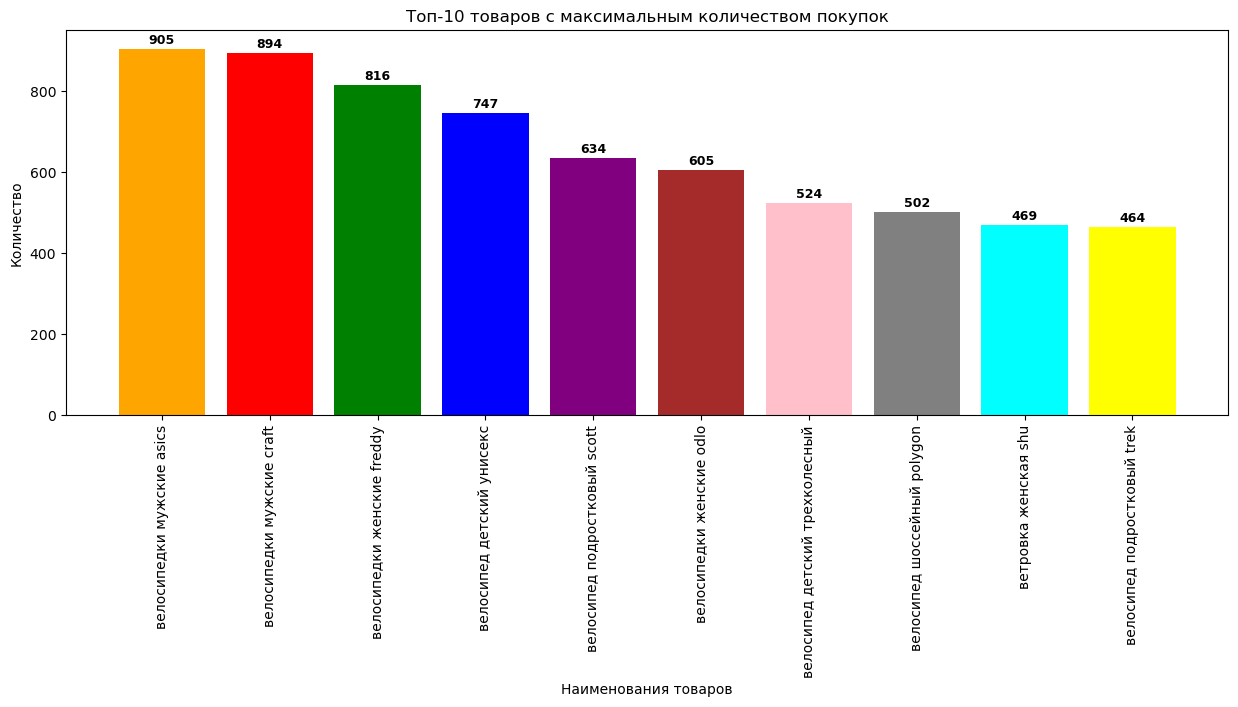

In [50]:
# Строим график с категорийными метками
plt.figure(figsize=(15, 5))  # Увеличим размер для читаемости
bars = plt.bar(max_count_product10['name'], max_count_product10['count'], 
               color=['orange', 'red', 'green', 'blue', 'purple', 
                      'brown', 'pink', 'gray', 'cyan', 'yellow'])

plt.xlabel('Наименования товаров')
plt.ylabel('Количество')
plt.title('Топ-10 товаров с максимальным количеством покупок')
plt.xticks(rotation=90)  # Наклон меток для читаемости


# Добавляем подписи значений над барами
for bar in bars:
    height = bar.get_height()
    plt.text(
        x=bar.get_x() + bar.get_width() / 2,  # Центр столбца по X
        y=height + 5,                       # Высота текста = высота столбца + отступ
        s=f'{height}',                        # Текст значения
        ha='center',                          # Горизонтальное выравнивание по центру
        va='bottom',                          # Вертикальное выравнивание по низу
        fontsize=9,
        fontweight='bold'
    )

#plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

In [219]:
# Сохраняем результаты
df_1188noTar.to_csv('data/prediction1188.csv', index=False)